In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import os
jax.devices()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]

In [3]:
import pandas as pd
from src import ComputationalHypergraphDiscovery as CHD
#from ComputationalHypergraphDiscovery.Modes import LinearMode, QuadraticMode, GaussianMode
import numpy as onp
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from tqdm import tqdm
import jax.numpy as np

In [4]:
additional=10

df=pd.read_csv('./BCR_uniform.csv')
df=df[df.columns[df.std(axis=0)!=0]]
relabel={n:n.replace('\\','/') for n in df.columns}
df.columns=[n.replace('\\','/') for n in df.columns]
cut=2400
df_train=df[:cut]
df_test=df[cut:]
df

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,$/partial_t S1112$,$/partial_t S1113$,$/partial_t S1114$,$/partial_t S1115$,$/partial_t S1116$,$/partial_t S1117$,$/partial_t S1118$,$/partial_t S1119$,$/partial_t S1120$,$/partial_t S1121$
0,0.872995,0.258391,0.222548,0.865075,0.006389,0.307317,0.689190,0.612599,0.032746,0.004956,...,414.121025,-607.379209,245.860647,1236.455751,3885.052506,1432.921968,2435.456029,1837.290757,664.621838,381.660465
1,0.177448,0.448519,0.892770,0.192859,0.771864,0.928737,0.017848,0.289916,0.000958,0.010268,...,355.803877,-858.675959,-2.037466,862.236998,2967.906927,2170.672995,2175.999670,2588.511472,1692.116035,1287.014376
2,0.340680,0.570078,0.998653,0.057214,0.491247,0.267313,0.412853,0.227748,0.658479,0.979586,...,212.052065,-430.789093,1091.800894,154.178383,3163.325683,1090.303392,1026.580469,1928.537903,2622.456177,550.399502
3,0.479903,0.526346,0.105414,0.382804,0.303066,0.459272,0.186838,0.460450,0.082807,0.546456,...,200.863198,-1554.053313,-890.349184,1708.265119,2454.615943,879.167918,2348.641473,1899.636315,2353.714969,1602.994661
4,0.779705,0.506842,0.873881,0.579235,0.133748,0.064157,0.164629,0.422048,0.720382,0.984089,...,-22.323701,-1081.489019,-1452.138727,1409.851417,2868.674541,1911.408665,3239.058777,2566.731976,981.383939,2672.800697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.741938,0.553394,0.122552,0.315124,0.605178,0.413084,0.535587,0.350225,0.756366,0.215708,...,244.472082,-529.148679,326.892413,879.321891,3084.463411,639.180626,1457.690128,2561.662390,1399.592603,738.031081
9996,0.976695,0.322520,0.061247,0.264253,0.976927,0.330817,0.650543,0.672399,0.353327,0.824186,...,60.713642,777.954782,-725.398390,1524.756426,1713.113517,1064.130513,1874.589536,2540.887684,-742.985098,1629.053069
9997,0.505065,0.177356,0.817247,0.856556,0.157023,0.521938,0.536912,0.888402,0.685757,0.966430,...,-73.246748,-426.498893,-241.613761,1596.848887,2476.240785,1243.812527,3107.594789,1865.723347,1313.990506,2303.902759
9998,0.156244,0.458165,0.306584,0.610349,0.179289,0.630377,0.554515,0.446829,0.517074,0.125642,...,-283.209440,-900.256308,96.279575,692.457902,2597.738457,1111.256518,2492.391004,2029.298082,52.398710,931.602062


In [5]:
possible_edges=nx.DiGraph()
edges=[]
for f_node in tqdm(df.columns):
    if 'partial' in f_node:
        continue
    for nf_node in df.columns:
        if 'partial' in nf_node:
            edges.append((f_node,nf_node))
            edges.append((nf_node,f_node))
possible_edges.add_edges_from(edges)

100%|██████████| 2244/2244 [00:01<00:00, 1309.55it/s]


In [6]:
graph_discovery=CHD.GraphDiscovery.from_dataframe(df_train,normalize=True,possible_edges=possible_edges,kernels=[CHD.Modes.QuadraticMode(memory_efficient_required=True)],gamma_min=1e-9)

Converting possible edges to dense adjacency matrix
making a function that is non-interpolatory


In [7]:
import glob

graphs = [pickle.load(open(path, "rb")) for path in tqdm(glob.glob('./results_all_uniform_BCR/*.pkl'))]
graphs = [nx.relabel_nodes(graph, relabel) for graph in graphs]

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


In [8]:
indexes_treated=[path.split('/')[-1][:-4].split('_')[-1] for path in glob.glob('./results_all_uniform_BCR/*.pkl')]
indexes_treated=[int(index) for index in indexes_treated]
indexes_treated

[5, 2, 3, 11, 4, 1, 9, 0, 6, 10, 7, 8]

In [9]:
for g in graphs:
    graph_discovery.G=nx.compose(graph_discovery.G,g)

In [10]:
true_graph=pickle.load(open('./BCR.pkl','rb'))
true_graph=nx.relabel_nodes(true_graph, relabel)

In [29]:
nx.ancestors(true_graph,'$/partial_t S0$')

{'S0',
 'S1',
 'S110',
 'S111',
 'S112',
 'S113',
 'S114',
 'S117',
 'S118',
 'S119',
 'S12',
 'S13',
 'S131',
 'S132',
 'S14',
 'S15',
 'S16',
 'S17',
 'S174',
 'S175',
 'S176',
 'S177',
 'S194',
 'S195',
 'S196',
 'S197',
 'S2',
 'S207',
 'S208',
 'S209',
 'S210',
 'S23',
 'S24',
 'S25',
 'S28',
 'S30',
 'S31',
 'S313',
 'S329',
 'S34',
 'S341',
 'S35',
 'S351',
 'S381',
 'S382',
 'S383',
 'S384',
 'S385',
 'S386',
 'S387',
 'S388',
 'S389',
 'S39',
 'S390',
 'S391',
 'S392',
 'S393',
 'S394',
 'S395',
 'S396',
 'S397',
 'S398',
 'S399',
 'S40',
 'S400',
 'S401',
 'S402',
 'S403',
 'S404',
 'S405',
 'S406',
 'S407',
 'S408',
 'S409',
 'S41',
 'S410',
 'S42',
 'S43',
 'S430',
 'S431',
 'S432',
 'S433',
 'S434',
 'S435',
 'S436',
 'S437',
 'S438',
 'S439',
 'S440',
 'S441',
 'S442',
 'S443',
 'S444',
 'S445',
 'S446',
 'S447',
 'S448',
 'S449',
 'S450',
 'S451',
 'S452',
 'S453',
 'S454',
 'S455',
 'S456',
 'S457',
 'S458',
 'S459',
 'S46',
 'S47',
 'S48',
 'S50',
 'S51',
 'S54',
 'S55

In [25]:
pruned_graph=nx.DiGraph()
pruned_graph.add_edges_from(graph_discovery.G.edges())

In [39]:
graph_discovery_truth=CHD.GraphDiscovery.from_dataframe(df_train,normalize=True,possible_edges=possible_edges,kernels=[CHD.Modes.QuadraticMode(memory_efficient_required=True)],gamma_min=1e-9)
graphs_truth = [pickle.load(open(path, "rb")) for path in tqdm(glob.glob('./results/*.pkl'))]
graphs_truth = [nx.relabel_nodes(graph, relabel) for graph in graphs_truth]
for g in graphs_truth:
    graph_discovery_truth.G=nx.compose(graph_discovery_truth.G,g)
noises={}
noises_list=[]
mode_chooser= CHD.decision.ThresholdModeChooser(threshold=0.025)
for node in graph_discovery_truth.G.nodes:
    if 'partial' not in node:
        continue
    node2=node.replace('/','\\')
    noise_record=np.load(f'./results/noise_evolution_{node2}.npy')
    index=mode_chooser(None,noise_record,None)
    noises[node]=float(noise_record[index])
    noises_list.append(float(noise_record[index]))
    if len(nx.ancestors(graph_discovery_truth.G,node))>=67 or noises[node]>=0.02:
        for ancestor in nx.ancestors(true_graph,node):
            pruned_graph.add_edge(ancestor,node)
    else:
        for ancestor in nx.ancestors(graph_discovery_truth.G,node):
            pruned_graph.add_edge(ancestor,node)
noises_list=np.array(noises_list)
noises

Converting possible edges to dense adjacency matrix
making a function that is non-interpolatory


100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


{'$/partial_t S0$': 2.317233889930572e-10,
 '$/partial_t S1$': 4.494115767654066e-09,
 '$/partial_t S2$': 6.082613813820675e-09,
 '$/partial_t S3$': 0.020080482551774675,
 '$/partial_t S4$': 3.0566776283342496e-09,
 '$/partial_t S5$': 6.571957058521989e-13,
 '$/partial_t S6$': 1.4700996925967743e-09,
 '$/partial_t S7$': 5.7068488989524585e-09,
 '$/partial_t S8$': 5.901769988105203e-09,
 '$/partial_t S9$': 9.761405114915805e-11,
 '$/partial_t S10$': 2.271249812143954e-13,
 '$/partial_t S11$': 2.1315594319056772e-13,
 '$/partial_t S12$': 1.2642591714839784e-10,
 '$/partial_t S13$': 1.9261751254828787e-10,
 '$/partial_t S14$': 5.944755187821881e-10,
 '$/partial_t S15$': 1.0806120286805252e-10,
 '$/partial_t S16$': 1.0293069957931241e-10,
 '$/partial_t S17$': 2.4678674714198086e-09,
 '$/partial_t S18$': 2.1571383012113695e-13,
 '$/partial_t S19$': 0.0008248010897841716,
 '$/partial_t S20$': 0.00048480418097900416,
 '$/partial_t S21$': 2.18229022375882e-13,
 '$/partial_t S22$': 2.1605529181

In [13]:
noises={}
noises_list=[]
mode_chooser= CHD.decision.ThresholdModeChooser(threshold=0.025)
for node in graph_discovery.G.nodes:
    if 'partial' not in node:
        continue
    node2=node.replace('/','\\')
    noise_record=np.load(f'./results_all_uniform_BCR/noise_evolution_{node2}.npy')
    index=mode_chooser(None,noise_record,None)
    noises[node]=float(noise_record[index])
    noises_list.append(float(noise_record[index]))
noises_list=np.array(noises_list)
noises

{'$/partial_t S0$': 8.607306913922454e-10,
 '$/partial_t S1$': 5.26772209453779e-09,
 '$/partial_t S2$': 8.21990383994078e-09,
 '$/partial_t S3$': 2.0621376288271599e-10,
 '$/partial_t S4$': 7.824707617170837e-09,
 '$/partial_t S5$': 7.505585845521163e-09,
 '$/partial_t S6$': 1.5620714217918009e-09,
 '$/partial_t S7$': 2.2805290968608147e-09,
 '$/partial_t S8$': 5.827840823218962e-09,
 '$/partial_t S9$': 1.4770709442396836e-09,
 '$/partial_t S10$': 2.6098362180123415e-09,
 '$/partial_t S11$': 1.883241133571982e-09,
 '$/partial_t S12$': 3.1078837642234833e-09,
 '$/partial_t S13$': 1.3235300302530375e-09,
 '$/partial_t S14$': 7.637529297494075e-10,
 '$/partial_t S15$': 1.0939009367084734e-09,
 '$/partial_t S16$': 3.396234103918702e-09,
 '$/partial_t S17$': 1.2803224155551175e-09,
 '$/partial_t S18$': 1.830314751347122e-09,
 '$/partial_t S19$': 2.26658560467329e-09,
 '$/partial_t S20$': 7.747185705881016e-11,
 '$/partial_t S21$': 5.258757935512494e-10,
 '$/partial_t S22$': 7.2265982118809

In [14]:
treated=[]
indices=nx.get_node_attributes(graph_discovery.G, "kernel_index")
for node in graph_discovery.G.nodes:
    try:
        indices[node]
        treated.append(node)
    except:
        pass

treated

['$/partial_t S0$',
 '$/partial_t S1$',
 '$/partial_t S2$',
 '$/partial_t S3$',
 '$/partial_t S4$',
 '$/partial_t S5$',
 '$/partial_t S6$',
 '$/partial_t S7$',
 '$/partial_t S8$',
 '$/partial_t S9$',
 '$/partial_t S10$',
 '$/partial_t S11$',
 '$/partial_t S12$',
 '$/partial_t S13$',
 '$/partial_t S14$',
 '$/partial_t S15$',
 '$/partial_t S16$',
 '$/partial_t S17$',
 '$/partial_t S18$',
 '$/partial_t S19$',
 '$/partial_t S20$',
 '$/partial_t S21$',
 '$/partial_t S22$',
 '$/partial_t S23$',
 '$/partial_t S24$',
 '$/partial_t S25$',
 '$/partial_t S26$',
 '$/partial_t S27$',
 '$/partial_t S28$',
 '$/partial_t S29$',
 '$/partial_t S30$',
 '$/partial_t S31$',
 '$/partial_t S32$',
 '$/partial_t S33$',
 '$/partial_t S34$',
 '$/partial_t S35$',
 '$/partial_t S36$',
 '$/partial_t S37$',
 '$/partial_t S38$',
 '$/partial_t S39$',
 '$/partial_t S40$',
 '$/partial_t S41$',
 '$/partial_t S42$',
 '$/partial_t S43$',
 '$/partial_t S44$',
 '$/partial_t S45$',
 '$/partial_t S46$',
 '$/partial_t S47$',
 '

In [15]:
active_mode_dic = nx.get_node_attributes(graph_discovery.G, "active_modes")
for node,active_mode in active_mode_dic.items():
    missing=graph_discovery.X.shape[1]-active_mode.shape[0]
    graph_discovery.G.nodes[node]["active_modes"] =jax.numpy.pad(active_mode,(0,missing),'constant',constant_values=(0,0))

In [16]:
k_dic = nx.get_node_attributes(graph_discovery.G, "kernel_index")
is_zero=np.array([k_dic.get(name, -1) for name in treated])==-1
is_zero

Array([False, False, False, ..., False, False, False], dtype=bool)

In [17]:
is_zero_mode=np.array([np.all(graph_discovery.G.nodes[name].get("active_modes",np.array([0]))==0) for name in treated])
is_zero_mode

Array([False, False, False, ..., False, False, False], dtype=bool)

In [18]:
is_zero=np.logical_or(is_zero,is_zero_mode)
is_zero

Array([False, False, False, ..., False, False, False], dtype=bool)

In [19]:
treated_and_non_zero=[t for t,z in zip(treated,is_zero) if not z]

In [16]:
pred = graph_discovery.predict(treated_and_non_zero,df_test.values)

In [ ]:
truth=df_test[treated_and_non_zero].values
truth.shape

(2605, 82)

In [ ]:
std=onp.std(truth,axis=0)

In [ ]:
pred.shape

(2605, 82)

In [ ]:
errors= jax.numpy.quantile((truth-pred)**2,0.99,axis=0)/std**2


In [ ]:
worst_res = graph_discovery.G.nodes[treated_and_non_zero[np.argmax(errors)]]
worst_res

{'active_modes': Array([1., 1., 1., ..., 0., 0., 0.], dtype=float64),
 'kernel_index': 0,
 'type': 'quadratic',
 'gamma': 0.00014998847214519015,
 'coeff': Array([ 0.05272845, -0.07050311,  0.22271914, ...,  0.02815014,
        -0.06413177,  0.15004197], dtype=float64)}

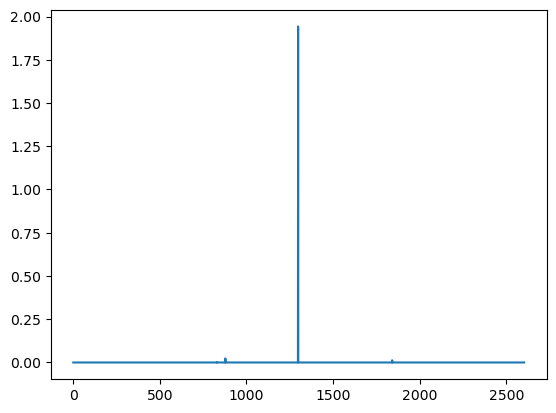

In [ ]:
errors_per_sample= jax.numpy.median((truth-pred)**2/std[None,:]**2,axis=1)
plt.plot(errors_per_sample[errors_per_sample<1000])

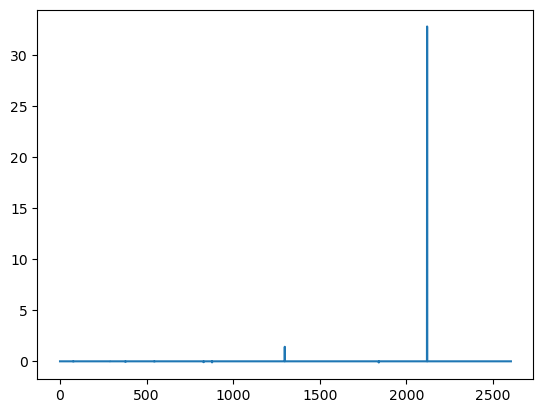

In [ ]:
plt.plot((truth-pred)[:,np.argmax(errors)]/std[np.argmax(errors)])

In [ ]:
np.sum(graph_discovery.G.nodes[treated_and_non_zero[1]]['active_modes'])

Array(16., dtype=float64)

In [ ]:
errors[::10]

Array([8.12409230e-12, 3.31782175e-15, 1.07268761e-12, 4.97261177e-14,
       1.92639534e-12, 1.45358860e-13, 4.61460441e-16, 1.82783951e-11,
       7.87782184e-15], dtype=float64)

In [ ]:
np.mean(np.log(errors))

Array(-30.93150515, dtype=float64)

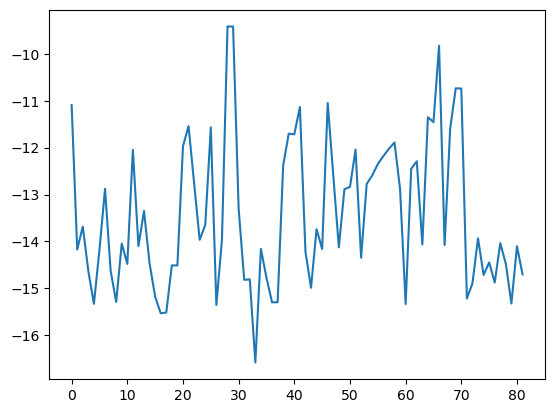

In [ ]:
plt.plot(jax.numpy.log10(errors))

In [ ]:
errors.shape

(82,)

In [ ]:
true_graph=pickle.load(open('./BCR.pkl','rb'))
true_graph=nx.relabel_nodes(true_graph, relabel)

In [37]:
#perform set intersection
set_1=nx.ancestors(pruned_graph,treated_and_non_zero[0])
set_2=nx.ancestors(graph_discovery.G,treated_and_non_zero[0])
intersection=set_1.intersection(set_2)
print(set_1)
print(set_2)
intersection

{'S407', 'S78', 'S9', 'S314', 'S2', 'S47', 'S79', 'S404', 'S402', 'S384', 'S444', 'S92', 'S16', 'S689', 'S371', 'S798', 'S430', 'S175', 'S432', 'S445', 'S12', 'S13', 'S686', 'S209', 'S329', 'S398', 'S34', 'S5', 'S454', 'S363', 'S447', 'S458', 'S340', 'S39', 'S451', 'S670', 'S408', 'S434', 'S401', 'S25', 'S166', 'S435', 'S135', 'S40', 'S71', 'S533', 'S1104', 'S193', 'S477', 'S207', 'S31', 'S114', 'S35', 'S256', 'S69', 'S909', 'S60', 'S195', 'S395', 'S7', 'S132', 'S91', 'S609', 'S438', 'S208', 'S335', 'S452', 'S410', 'S386', 'S3', 'S436', 'S110', 'S17', 'S392', 'S55', 'S6', 'S118', 'S28', 'S196', 'S878', 'S396', 'S405', 'S732', 'S354', 'S90', 'S945', 'S433', 'S446', 'S351', 'S77', 'S131', 'S306', 'S443', 'S464', 'S399', 'S403', 'S449', 'S440', 'S117', 'S394', 'S448', 'S291', 'S14', 'S176', 'S165', 'S442', 'S437', 'S42', 'S68', 'S30', 'S381', 'S70', 'S210', 'S388', 'S199', 'S62', 'S243', 'S406', 'S391', 'S15', 'S857', 'S390', 'S171', 'S50', 'S455', 'S797', 'S305', 'S890', 'S500', 'S177', 

{'S1074',
 'S1104',
 'S12',
 'S125',
 'S135',
 'S161',
 'S165',
 'S166',
 'S167',
 'S17',
 'S171',
 'S193',
 'S199',
 'S21',
 'S243',
 'S256',
 'S291',
 'S3',
 'S305',
 'S306',
 'S314',
 'S335',
 'S337',
 'S340',
 'S354',
 'S363',
 'S371',
 'S381',
 'S382',
 'S399',
 'S406',
 'S419',
 'S430',
 'S431',
 'S458',
 'S461',
 'S464',
 'S47',
 'S477',
 'S493',
 'S5',
 'S500',
 'S524',
 'S528',
 'S533',
 'S6',
 'S60',
 'S609',
 'S62',
 'S642',
 'S670',
 'S686',
 'S689',
 'S732',
 'S797',
 'S798',
 'S828',
 'S842',
 'S857',
 'S878',
 'S888',
 'S890',
 'S9',
 'S909',
 'S92',
 'S941',
 'S945',
 'S965'}

In [ ]:
onp.sort([int(n[1:]) for n in nx.ancestors(true_graph,treated_and_non_zero[0])])

array([  1,   4, 341, 349, 468, 792, 812, 821, 822, 875, 926])

In [ ]:
onp.sort([int(n[1:]) for n in nx.ancestors(graph_discovery.G,treated_and_non_zero[0])])

array([   2,    9,   15,   18,   66,   81,  101,  157,  164,  169,  172,
        182,  193,  216,  218,  222,  241,  273,  288,  312,  327,  363,
        369,  375,  397,  416,  418,  419,  420,  435,  440,  468,  487,
        498,  520,  537,  549,  573,  612,  621,  629,  636,  663,  684,
        697,  718,  720,  728,  735,  773,  778,  787,  792,  807,  822,
        831,  866,  895,  917,  926,  965,  992, 1044, 1045, 1047, 1073,
       1114, 1118])

680


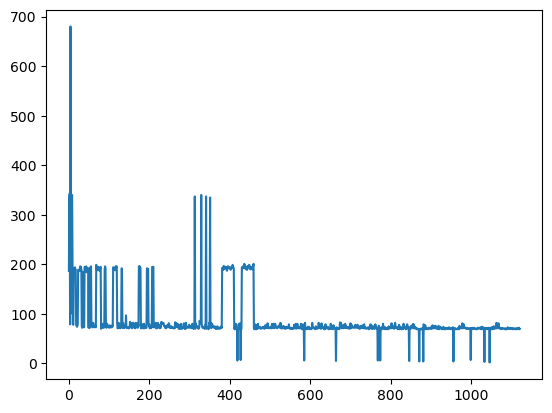

In [40]:
ancestors=np.array([len(nx.ancestors(pruned_graph,node)) for node in treated_and_non_zero])
plt.plot(ancestors)
print(np.max(ancestors))

649


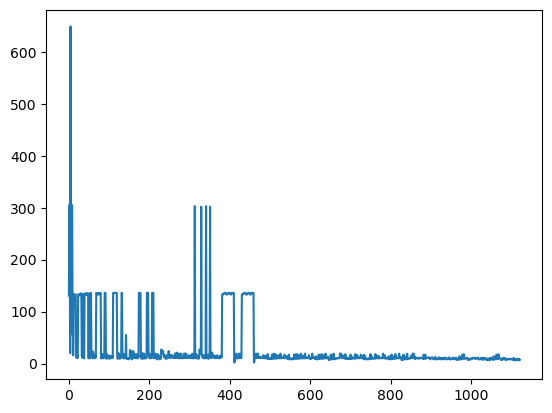

In [41]:
ancestors=np.array([len(nx.ancestors(true_graph,node)) for node in treated_and_non_zero])
plt.plot(ancestors)
print(np.max(ancestors))

In [ ]:
#solve 2400=n(n+3)/2
n=int((onp.sqrt(1+8*2400)-3)/2)
n

67

In [ ]:
n*(n+3)/2

2345.0

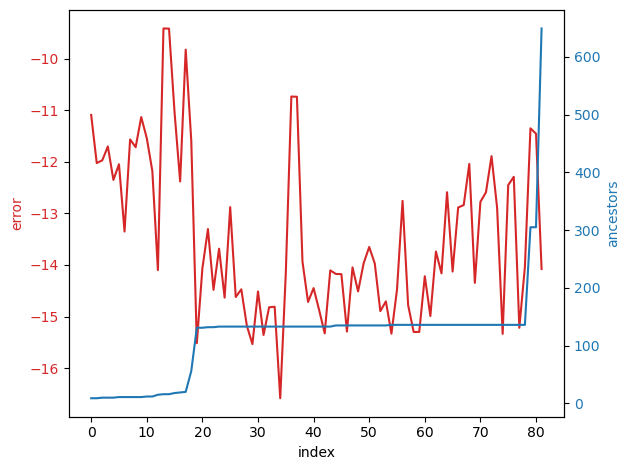

In [ ]:
#plot two plots with different y axis
fig, ax1 = plt.subplots()
indexes=np.argsort(ancestors)

color = 'tab:red'
ax1.set_xlabel('index')
ax1.set_ylabel('error', color=color)
ax1.plot(np.log10(errors)[indexes], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('ancestors', color=color)  # we already handled the x-label with ax1
ax2.plot((ancestors)[indexes], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
true_graph.nodes

NodeView(('S0', '$/partial_t S0$', 'S1', '$/partial_t S1$', 'S2', '$/partial_t S2$', 'S3', '$/partial_t S3$', 'S4', '$/partial_t S4$', 'S5', '$/partial_t S5$', 'S6', '$/partial_t S6$', 'S7', '$/partial_t S7$', 'S8', '$/partial_t S8$', 'S9', '$/partial_t S9$', 'S10', '$/partial_t S10$', 'S11', '$/partial_t S11$', 'S12', '$/partial_t S12$', 'S13', '$/partial_t S13$', 'S14', '$/partial_t S14$', 'S15', '$/partial_t S15$', 'S16', '$/partial_t S16$', 'S17', '$/partial_t S17$', 'S18', '$/partial_t S18$', 'S19', '$/partial_t S19$', 'S20', '$/partial_t S20$', 'S21', '$/partial_t S21$', 'S22', '$/partial_t S22$', 'S23', '$/partial_t S23$', 'S24', '$/partial_t S24$', 'S25', '$/partial_t S25$', 'S26', '$/partial_t S26$', 'S27', '$/partial_t S27$', 'S28', '$/partial_t S28$', 'S29', '$/partial_t S29$', 'S30', '$/partial_t S30$', 'S31', '$/partial_t S31$', 'S32', '$/partial_t S32$', 'S33', '$/partial_t S33$', 'S34', '$/partial_t S34$', 'S35', '$/partial_t S35$', 'S36', '$/partial_t S36$', 'S37', '$/p

In [ ]:
true_graph.edges

OutEdgeView([('S0', '$/partial_t S0$'), ('S0', '$/partial_t S1$'), ('S0', '$/partial_t S6$'), ('S0', '$/partial_t S2$'), ('S0', '$/partial_t S9$'), ('S0', '$/partial_t S7$'), ('S0', '$/partial_t S12$'), ('S0', '$/partial_t S13$'), ('S0', '$/partial_t S14$'), ('S0', '$/partial_t S8$'), ('S0', '$/partial_t S17$'), ('S0', '$/partial_t S15$'), ('S0', '$/partial_t S16$'), ('S0', '$/partial_t S24$'), ('S0', '$/partial_t S30$'), ('S0', '$/partial_t S23$'), ('S0', '$/partial_t S25$'), ('S0', '$/partial_t S31$'), ('S0', '$/partial_t S34$'), ('S0', '$/partial_t S28$'), ('S0', '$/partial_t S35$'), ('S0', '$/partial_t S40$'), ('S0', '$/partial_t S42$'), ('S0', '$/partial_t S54$'), ('S0', '$/partial_t S39$'), ('S0', '$/partial_t S41$'), ('S0', '$/partial_t S43$'), ('S0', '$/partial_t S46$'), ('S0', '$/partial_t S50$'), ('S0', '$/partial_t S55$'), ('S0', '$/partial_t S47$'), ('S0', '$/partial_t S48$'), ('S0', '$/partial_t S51$'), ('S0', '$/partial_t S69$'), ('S0', '$/partial_t S71$'), ('S0', '$/part

In [ ]:
graph_discovery.G.edges

OutEdgeView([('S0', '$/partial_t S20$'), ('S0', '$/partial_t S21$'), ('S0', '$/partial_t S22$'), ('S0', '$/partial_t S84$'), ('S0', '$/partial_t S33$'), ('S0', '$/partial_t S10$'), ('S0', '$/partial_t S11$'), ('S0', '$/partial_t S14$'), ('S0', '$/partial_t S15$'), ('S0', '$/partial_t S16$'), ('S0', '$/partial_t S57$'), ('S0', '$/partial_t S59$'), ('S0', '$/partial_t S163$'), ('S0', '$/partial_t S95$'), ('S0', '$/partial_t S126$'), ('S0', '$/partial_t S129$'), ('S0', '$/partial_t S156$'), ('S0', '$/partial_t S0$'), ('S0', '$/partial_t S1$'), ('S0', '$/partial_t S2$'), ('S0', '$/partial_t S6$'), ('S0', '$/partial_t S9$'), ('S1', '$/partial_t S20$'), ('S1', '$/partial_t S21$'), ('S1', '$/partial_t S22$'), ('S1', '$/partial_t S82$'), ('S1', '$/partial_t S84$'), ('S1', '$/partial_t S10$'), ('S1', '$/partial_t S11$'), ('S1', '$/partial_t S57$'), ('S1', '$/partial_t S59$'), ('S1', '$/partial_t S163$'), ('S1', '$/partial_t S95$'), ('S1', '$/partial_t S126$'), ('S1', '$/partial_t S129$'), ('S1'

In [22]:
#compute the true positives and false negatives. For each edge in graph_discovery.G, if it is in true_graph, it is a true positive, otherwise it is a false positive
#true_graph is a networkx graph, graph_discovery.G is a networkx graph
true_positives={}
false_positives={}
false_negatives={}
true_negatives={}
random_true_positives={}
random_false_positives={}
random_false_negatives={}
random_true_negatives={}
for node in graph_discovery.G.nodes:
    if 'partial' not in node:
        continue
    true_positives[node]=0
    false_positives[node]=0
    false_negatives[node]=0
    true_negatives[node]=0
    true_ancestor_number=len(nx.ancestors(true_graph,node))
    ancestor_number=len(nx.ancestors(graph_discovery.G,node))
    random_true_positives[node]=true_ancestor_number*ancestor_number/1122
    random_false_positives[node]=(1122-true_ancestor_number)*ancestor_number/1122
    random_false_negatives[node]=true_ancestor_number*(1122-ancestor_number)/1122
    random_true_negatives[node]=(1122-true_ancestor_number)*(1122-ancestor_number)/1122

    for ancestor in graph_discovery.G.nodes:
        if 'partial' in ancestor:
            continue
        predicted=graph_discovery.G.has_edge(ancestor,node)
        true=true_graph.has_edge(ancestor,node)
        
        if predicted and true:
            true_positives[node]+=1
        elif predicted and not true:
            false_positives[node]+=1
        elif not predicted and true:
            false_negatives[node]+=1
        else:
            true_negatives[node]+=1


true_positive_rates={node:true_positives[node]/(true_positives[node]+false_negatives[node]) for node in true_positives}
false_positive_rates={node:false_positives[node]/(false_positives[node]+true_negatives[node]) for node in false_positives}
false_discovery_rates={node:false_positives[node]/(false_positives[node]+true_positives[node]) for node in false_positives}
true_negative_rates={node:true_negatives[node]/(true_negatives[node]+false_positives[node]) for node in true_negatives}
random_true_positive_rates={node:random_true_positives[node]/(random_true_positives[node]+random_false_negatives[node]) for node in random_true_positives}
random_false_positive_rates={node:random_false_positives[node]/(random_false_positives[node]+random_true_negatives[node]) for node in random_false_positives}
random_false_discovery_rates={node:random_false_positives[node]/(random_false_positives[node]+random_true_positives[node]) for node in random_false_positives}
random_true_negative_rates={node:random_true_negatives[node]/(random_true_negatives[node]+random_false_positives[node]) for node in random_true_negatives}


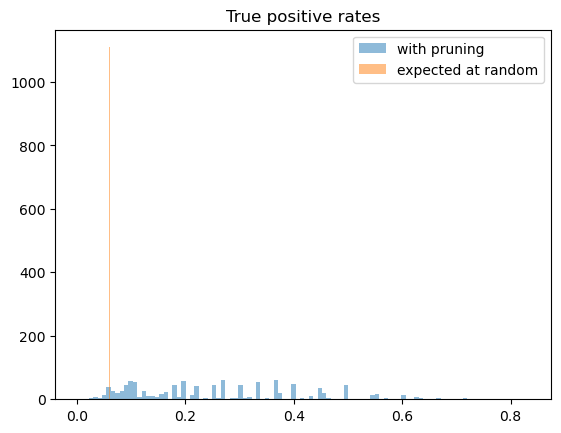

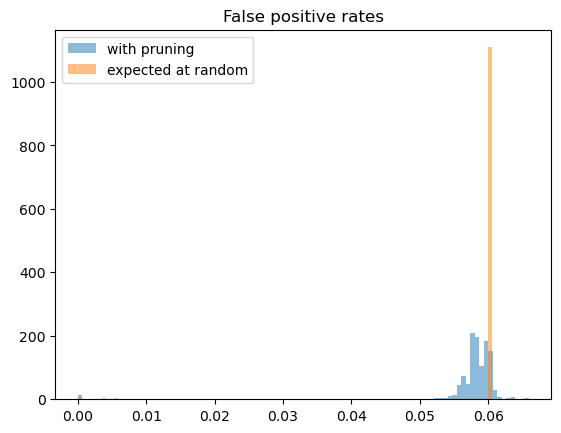

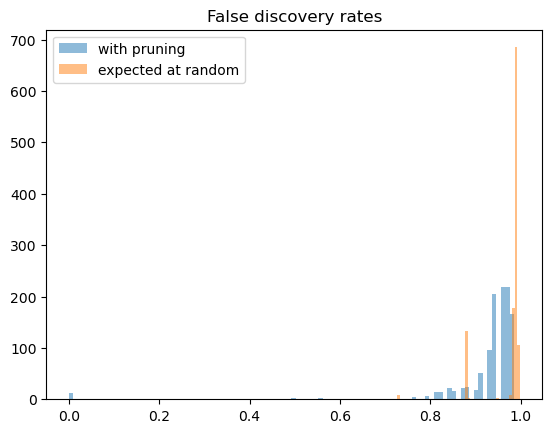

In [34]:
plt.figure()
data=list(true_positive_rates.values())
data_random=list(random_true_positive_rates.values())
plt.hist(data,bins=100,density=False,alpha=0.5,label='with pruning')
plt.hist(data_random,bins=100,density=False,alpha=0.5,label='expected at random',range=(0,1))
plt.title('True positive rates')
plt.legend()
plt.figure()
plt.hist(list(false_positive_rates.values()),bins=100,density=False,alpha=0.5,label='with pruning')
plt.hist(list(random_false_positive_rates.values()),bins=100,density=False,alpha=0.5,label='expected at random')
plt.title('False positive rates')
plt.legend()
plt.figure()
plt.hist(list(false_discovery_rates.values()),bins=100,density=False,alpha=0.5,label='with pruning')
plt.hist(list(random_false_discovery_rates.values()),bins=100,density=False,alpha=0.5,label='expected at random')
plt.title('False discovery rates')
plt.legend()
plt.show()

In [43]:
true_positives

4764

In [44]:
false_positives

70713

# No pruning

In [ ]:
active_mode = np.array([1]*(graph_discovery.X.shape[1]//2)+[0]*(graph_discovery.X.shape[1]//2))
K_mat=graph_discovery.kernels[0](graph_discovery.X,graph_discovery.X,active_mode)

In [ ]:
gamma = -np.linalg.eigvalsh(K_mat)[0]*2

In [ ]:
ybs=jax.scipy.linalg.solve(K_mat+gamma*np.eye(K_mat.shape[0]),graph_discovery.X,assume_a='pos')
ybs

Array([[ 0.00186861,  0.00774787,  0.00842719, ...,  0.01440706,
         0.00630739, -0.04443163],
       [-0.002234  , -0.01032468, -0.01135911, ..., -0.02440178,
         0.02869952,  0.05869252],
       [-0.00073848,  0.00043968,  0.00161683, ...,  0.0003194 ,
         0.00145501,  0.00033377],
       ...,
       [ 0.01344884, -0.00279767, -0.00082302, ..., -0.02306134,
         0.13900466,  0.03221073],
       [-0.00270629,  0.00026317, -0.00072329, ..., -0.0002951 ,
        -0.00026564,  0.00053216],
       [ 0.00356438, -0.00047125,  0.00062743, ...,  0.00042393,
         0.000693  , -0.00037533]], dtype=float64)

In [ ]:
indexes_treated=np.array([graph_discovery.name_to_index[name] for name in treated_and_non_zero])
ybs=ybs[:,indexes_treated]
ybs.shape

(2400, 82)

In [ ]:
df_test[treated_and_non_zero].values.shape

(2605, 82)

In [ ]:
graph_discovery.X.shape

(2400, 2244)

In [ ]:
K_pred=graph_discovery.kernels[0](df_test.values,graph_discovery.X,active_mode)

In [ ]:
pred_no_pruning=K_pred@ybs

In [ ]:
diffs_no_pruning=(df_test[treated_and_non_zero].values-pred_no_pruning)

In [ ]:
errors= jax.numpy.median((diffs_no_pruning)**2,axis=0)/std**2

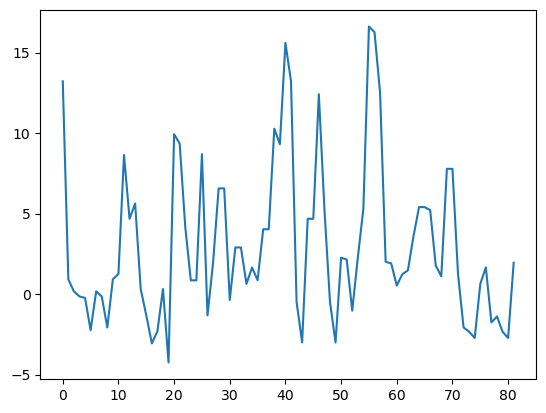

In [ ]:
plt.plot(np.log10(errors))